In [221]:
from datasets import load_dataset

dataset = load_dataset("tweet_eval", "stance_atheism")

Reusing dataset tweet_eval (/Users/gokul/.cache/huggingface/datasets/tweet_eval/stance_atheism/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

# Data loading

In [222]:
tweets = dataset["train"]['text'] + dataset["test"]['text'] + dataset["validation"]['text']
labels = dataset["train"]['label'] + dataset["test"]['label'] + dataset["validation"]['label']
df = pd.DataFrame(columns={"tweet", "label"})
df["tweet"] = tweets
df["label"] = labels
df.head()

,tweet,label
0,"@user Bless Almighty God, Almighty Holy Spirit...",1
1,"Take away hatred from some people, and you hav...",1
2,I took my troubles to the Lord: I cried out to...,1
3,You can't think by yourself about life and bel...,2
4,RT @user Humanist love to everyone at #100AEUA...,0


In [223]:
print("Number of records in the dataset : ", df.shape[0])
print("Number of columns in the dataset : ", len(df.columns), "  ==> ", list(df.columns))
print()
print("Label legend :")
print()
print("0 : Neutral ")
print("1 : Against atheism")
print("2 : Favours atheism")
print()

Number of records in the dataset :  733
Number of columns in the dataset :  2   ==>  ['tweet', 'label']

Label legend :

0 : Neutral 
1 : Against atheism
2 : Favours atheism



# Drop duplicates or Null values from the dataset

In [224]:
df.dropna(inplace=True)
df.isnull().sum()

tweet    0
label    0
dtype: int64

In [225]:
df.shape

(733, 2)

## Distribution of tweets among categories

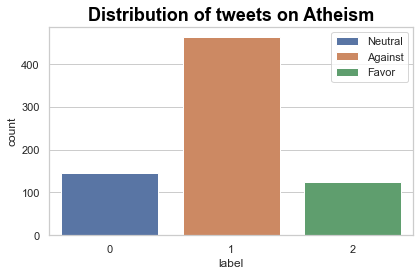

In [226]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
g = sns.countplot(x='label', data=df, hue='label', dodge=False)
plt.title('Distribution of tweets on Atheism', fontsize=18, fontweight='bold', color='black')
plt.legend(loc='upper right', labels=['Neutral','Against','Favor'])
plt.tight_layout()
plt.show()

### The distribution suggests skeweness among categories

# Average number of characters in tweet based on the category

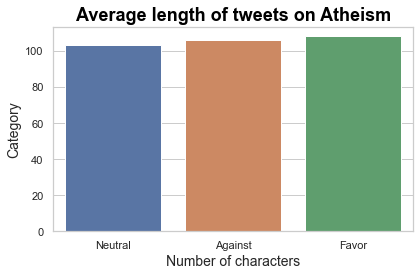

In [227]:
mapping_char_length = {0:0,1:0,2:0}


def count_chars(row):
    global mapping_char_length
    mapping_char_length[row['label']] += len(row['tweet'])

df.apply(count_chars, axis=1)

counts = {}
for val, cnt in df.value_counts('label').iteritems():
    counts[val] = cnt

average_length = {}
for key in list(counts.keys()):
    average_length[key] = mapping_char_length[key] // counts[key]

keys = list(average_length.keys())
vals = [average_length[k] for k in keys]
sns.barplot(x=keys, y=vals)
plt.title('Average length of tweets on Atheism', fontsize=18, fontweight='bold', color='black')
plt.xlabel('Number of characters', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.xticks([0, 1, 2], ['Neutral', 'Against', 'Favor'])
plt.tight_layout()
plt.show()


### The average number of characters among categories seem to be the same. Although, this may be strongly due to Twitter's limit of characters in a tweet.

# Expand commonly contracted words , remove punctuations , remove stopwords
### for example, cant , can't => cannot
### yolo => yolo 
### remove is, was, of, an, etc.

In [228]:
!pip install --user -U nltk
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.9 MB 7.0 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [229]:
import contractions
import collections
import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy

en = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words('english'))
stop_words = stop_words.union(set(en.Defaults.stop_words))


words_dictionary = {0: set(), 1:set(), 2:set()}
words_dictionary_with_duplicates = {0: [], 1:[], 2:[]}

def process_tweet(row):
    global words_dictionary
    tweet = row["tweet"]
    final_tweet = ""
    for word in tweet.split(" "):
        final_tweet = final_tweet + " " + contractions.fix(word)

    tokenizer = RegexpTokenizer(r'\w+')
    final_tweet = tokenizer.tokenize(final_tweet)
    for word in final_tweet:
        if word not in stop_words:
            if word not in words_dictionary[row["label"]]:
                words_dictionary[row["label"]].add(word)
            words_dictionary_with_duplicates[row["label"]].append(word.lower())
    row["tweet"] = " ".join(final_tweet)
    return row
    
df = df.apply(process_tweet, axis=1)
df.head()

[nltk_data] Downloading package punkt to /Users/gokul/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/gokul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,tweet,label
0,user Bless Almighty God Almighty Holy Spirit a...,1
1,Take away hatred from some people and you have...,1
2,I took my troubles to the Lord I cried out to ...,1
3,You cannot think by yourself about life and be...,2
4,RT user Humanist love to everyone at 100AEUAss...,0


# Wordcloud for each category

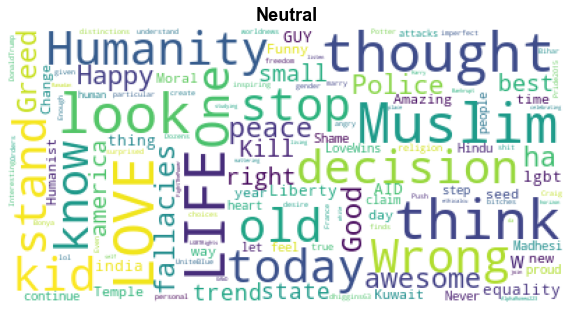

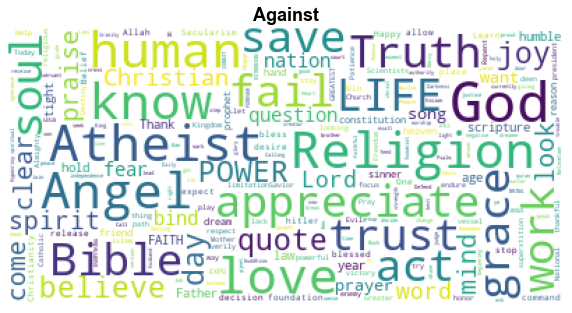

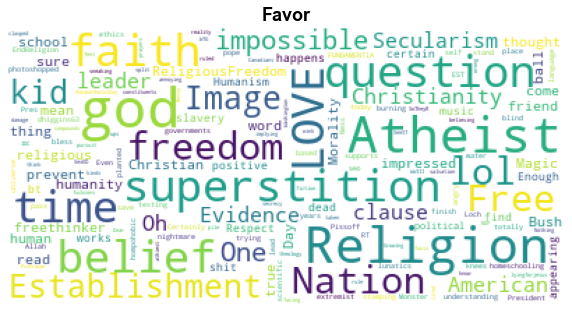

In [230]:
from wordcloud import WordCloud

titles = {0: "Neutral", 1:"Against", 2:"Favor"}

for key in words_dictionary.keys():
    text = " ".join(list(words_dictionary[key]))
    wordcloud = WordCloud().generate(text)
    wordcloud = WordCloud(background_color="white",max_words=len(text),max_font_size=40, relative_scaling=.5).generate(text)
   
    plt.figure(figsize=(10,10))
    plt.title(titles[key], fontsize=18, fontweight='bold', color='black')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

# Top 15 words in each category visualized

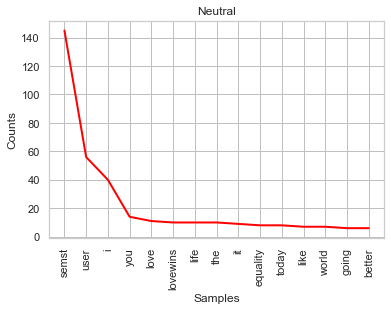

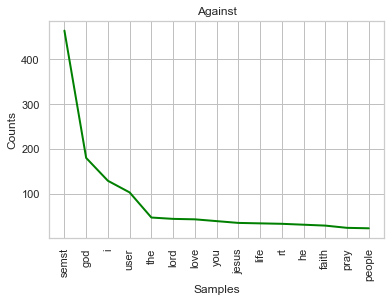

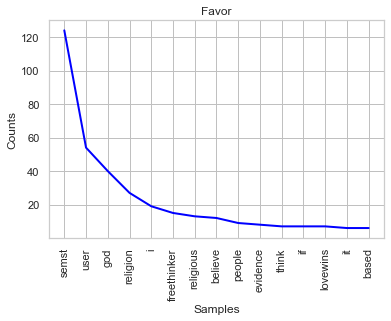

In [231]:
from nltk.probability import FreqDist
colors = ["red", "green", "blue"]

for key in list(words_dictionary_with_duplicates.keys()):
    frequent_words = FreqDist(words_dictionary_with_duplicates[key])
    frequent_words.most_common(15)
    frequent_words.plot(15, color=colors[key], title=titles[key])

# Perform sentiment analysis on the tweets

In [232]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

def sentiment(row):
    global sid
    sentiments = sid.polarity_scores(row["tweet"])
    row["positive"] = sentiments["pos"]
    row["negative"] = sentiments["neg"]
    row["neutral"] = sentiments["neu"]
    row["compound"] = sentiments["compound"]
    return row

df = df.apply(sentiment, axis=1)

In [233]:
new_df = df.drop(columns=["tweet"])
new_df = new_df.groupby('label').mean()

# Distribution of sentiment (positive, negative, neutral and compound emotion) in each category 

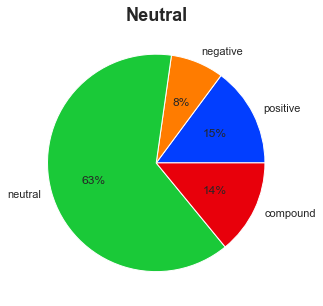

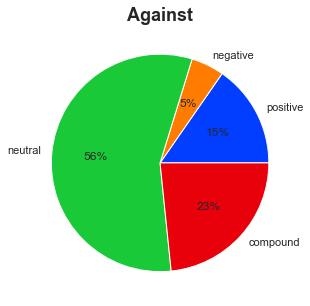

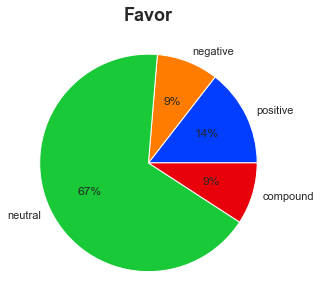

In [234]:
palette_color = sns.color_palette('bright')

sentiment_stats = {}
for row in new_df.iterrows():
    idx = row[0]
    row = list(row[1])
    item = {}
    item["positive"] = row[0]
    item["negative"] = row[1]
    item["neutral"] = row[2]
    item["compound"] = row[3]
    sentiment_stats[idx] = item

for i in list(sentiment_stats.keys()):
    vals = []
    for s in sentiment_stats[i]:
        vals.append(sentiment_stats[i][s])
    plt.figure(figsize=(10,5))
    plt.title(titles[i], fontsize=18, fontweight="bold")
    plt.pie(vals, labels=new_df.columns, colors=palette_color, autopct='%.0f%%')
    plt.show()

# Reason for choosing the dataset

I spent quite a lot of time looking at the datasets suitable for EDA but the quality of the dataset and EDA capabilities 
did not seem to overlap in most cases. Also, it was easier to showcase EDA on datasets that have many quantitative
fields. But is challenging to gain insights from textual data where there are no derived features from it. I wanted to
take up this task to explore such datasets. I am also interested in NLP/ASR related datasets. I tend to be more interested in doing things related to the things
I am passionate about. It was certainly tougher to bring out insights when you just have a text column and one label in your entire dataset.

I refrained from using Stemming/lemmatization as they are aggressive for this kind of data and they also dont much insights I believe. I was personally outright curious about what I can end up infering from this dataset.
